In [70]:
from mplfinance.original_flavor import candlestick_ohlc 
import yfinance as yf  
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import scipy.stats as st
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from pandas.plotting import autocorrelation_plot
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

# Coca-Cola

In [19]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-1-1')
    return tickerDf.iloc[:, :5]

In [20]:
df_KO = get_price_data('KO')

## EDA

In [21]:
df_KO.head(10)

Open       High        Low      Close  \
Date                                                                    
2017-01-03 00:00:00-05:00  33.463260  33.713227  33.285863  33.705162   
2017-01-04 00:00:00-05:00  33.769680  33.842251  33.535839  33.584221   
2017-01-05 00:00:00-05:00  33.592285  33.753554  33.487459  33.664856   
2017-01-06 00:00:00-05:00  33.624537  33.713236  33.495522  33.656792   
2017-01-09 00:00:00-05:00  33.245552  33.527774  33.229425  33.318123   
2017-01-10 00:00:00-05:00  33.414882  33.414882  32.947204  33.092346   
2017-01-11 00:00:00-05:00  32.939141  33.156854  32.923017  33.100410   
2017-01-12 00:00:00-05:00  33.068154  33.092346  32.898823  33.019775   
2017-01-13 00:00:00-05:00  33.060086  33.092340  32.810118  32.963326   
2017-01-17 00:00:00-05:00  32.931073  33.301990  32.898818  33.237484   

                             Volume  
Date                                 
2017-01-03 00:00:00-05:00  14711000  
2017-01-04 00:00:00-05:00   9959400  
2017-01-05 00:00:00-05:00   8968300  
2017-01-06 00:00:00-05:00  10246600  
2017-01-09 00:00:00-05:00  14822500  
2017-01-10 00:00:00-05:00  19706800  
2017-01-11 00:00:00-05:00   9266200  
2017-01-12 00:00:00-05:00   8541200  
2017-01-13 00:00:00-05:00   8123500  
2017-01-17 00:00:00-05:00  12469400

In [22]:
df_KO.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1510 non-null   float64
 1   High    1510 non-null   float64
 2   Low     1510 non-null   float64
 3   Close   1510 non-null   float64
 4   Volume  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [26]:
df_KO.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [23]:
df_KO.corr()

Open      High       Low     Close    Volume
Open    1.000000  0.999210  0.998904  0.998257  0.133587
High    0.999210  1.000000  0.998589  0.999055  0.143909
Low     0.998904  0.998589  1.000000  0.999198  0.113337
Close   0.998257  0.999055  0.999198  1.000000  0.126372
Volume  0.133587  0.143909  0.113337  0.126372  1.000000

In [24]:
df_KO.describe()

Open         High          Low        Close        Volume
count  1510.000000  1510.000000  1510.000000  1510.000000  1.510000e+03
mean     45.691588    46.021383    45.349287    45.687474  1.427266e+07
std       8.137543     8.216545     8.052936     8.144227  6.465218e+06
min      32.560149    32.737543    32.431134    32.608536  2.996300e+06
25%      38.459479    38.668212    38.229083    38.454539  1.015468e+07
50%      44.911796    45.238409    44.581116    44.817310  1.283005e+07
75%      51.221970    51.558940    51.028910    51.282424  1.641978e+07
max      64.073536    64.264797    62.849440    63.318035  6.784570e+07

In [25]:
def statistic_report(df, column):
    confidence_interval = st.t.interval(0.95, len(df)-1, loc=df[column].mean(), scale=df[column].std()/np.sqrt(len(df)))
    print(f'Среднее значение: {df[column].mean()}, доверительный интервал (95%): {confidence_interval}\nМедианное значение: {df[column].median()}\nСтандартное отклонение: {df[column].std()}\nМаксимальное значение: {df[column].max()}\nМинимальное значение: {df[column].min()}')

In [28]:
statistic_report(df_KO, 'Close')

Среднее значение: 45.68747441373913, доверительный интервал (95%): (45.27636450124238, 46.09858432623589)
Медианное значение: 44.81731414794922
Стандартное отклонение: 8.144226618194748
Максимальное значение: 63.31803894042969
Минимальное значение: 32.60853958129883


У нас есть датасет с ценами на акции Coca-Cola. В датасете есть пять столбцов: цена открытия, самая низкая цена, самая высокая цена, цена закрытия и объем акций. Данные записаны ежедневно, за исключением выходных и праздничных дней. Всего в датасете 1510 наблюдений, пропущенных значений нет. Коэффициенты корреляции между ценами Open, Low, High, Close достаточно высоки (не ниже 0,99), дальнейший расчет будет вести по колонке Close. Для данной колонки было определены статистические параметры и среднее значение с 95% вероятностью находится в диапазоне от 45,2763 до 46,0985.

## Visualization

In [31]:
def plot_visualization(df, column, company):
    plt.figure(figsize=(12, 6))

    df[column].plot()
    plt.ylabel(column)
    plt.xlabel(None)
    plt.title(f"{company} stock price")
    
    plt.tight_layout()

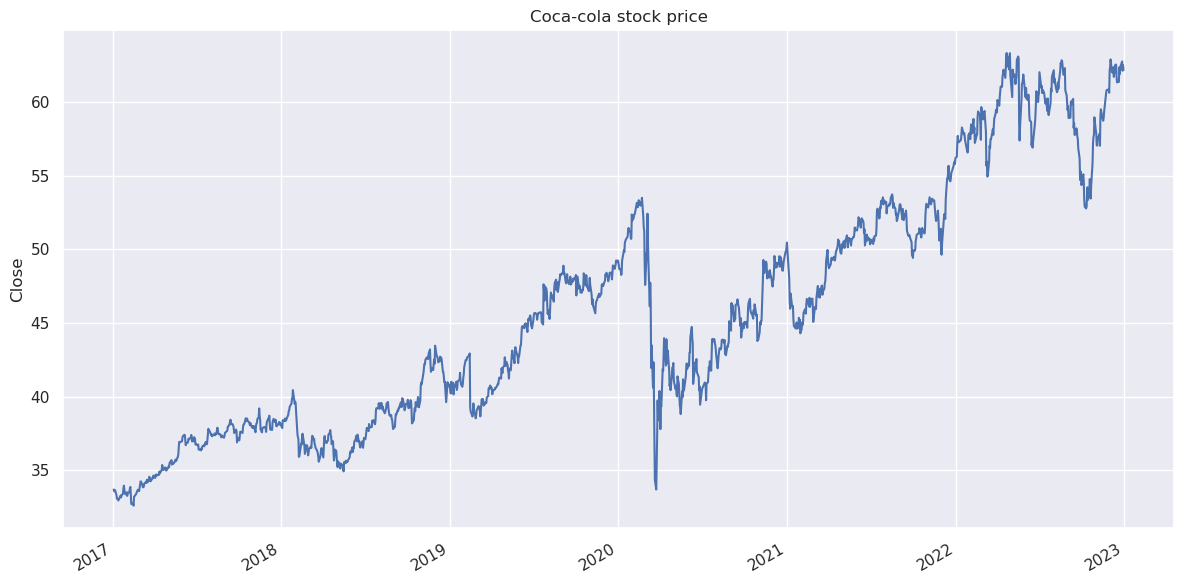

In [32]:
plot_visualization(df_KO, 'Close', 'Coca-cola')

<Axes: >

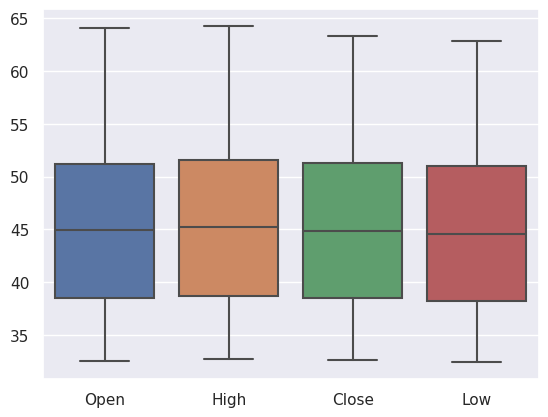

In [43]:
sns.boxplot(data = df_KO[['Open', 'High', 'Close', 'Low']])

In [99]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

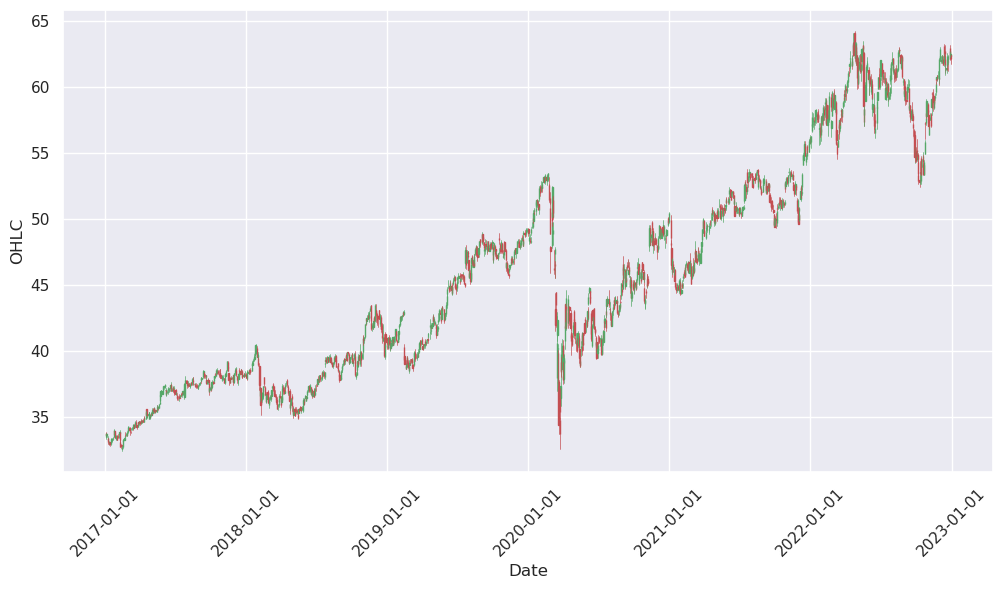

In [36]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(df_KO, fig.subplots())
plt.show()

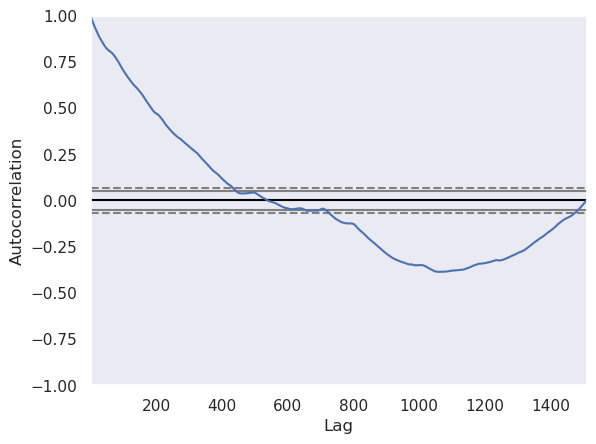

In [37]:
autocorrelation_plot(df_KO['Close'])
plt.show()

In [37]:
 def series_decompose(series):
    result = seasonal_decompose(series, model='multiplicative', period=365)

    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(series, label='Original')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

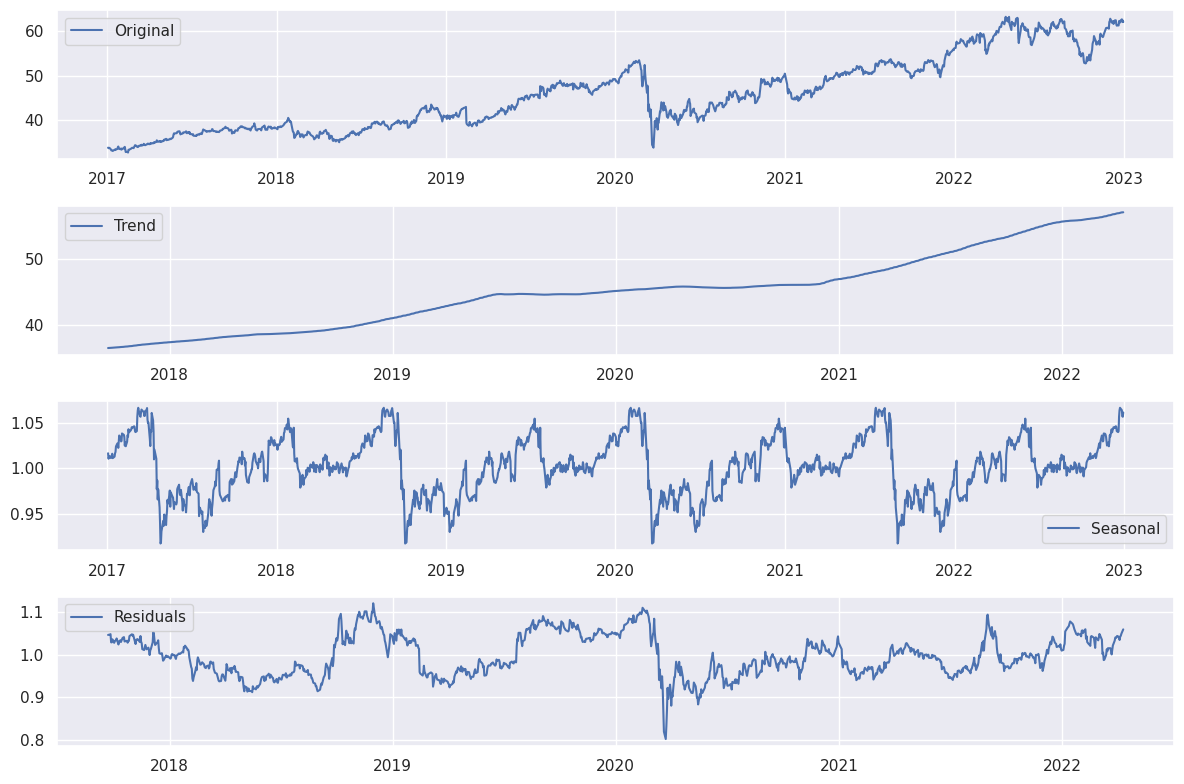

In [39]:
series_decompose(df_KO['Close'])

<Axes: xlabel='Close', ylabel='Count'>

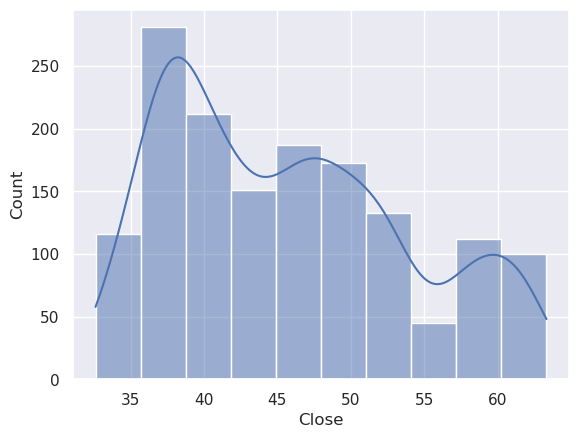

In [41]:
sns.histplot(data=df_KO, x='Close', bins=10, kde=True)

**Вывод:** Из графиков видно, что распеделение целевой переменной не имеет нормальное распределение. На боксплотах нет выбросов в данных. При разложении ряда получили растущий тренд, присутствует сезонность. В начале 2020 года акции упали, что вероятнее всего было связано с пандемией.

## Stationarity

In [107]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [105]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   -0.896530
p-value                           0.789113
#Lags Used                       12.000000
Number of Observations Used    1497.000000
Critical Value (1%)              -3.434726
Critical Value (5%)              -2.863473
Critical Value (10%)             -2.567799
dtype: float64


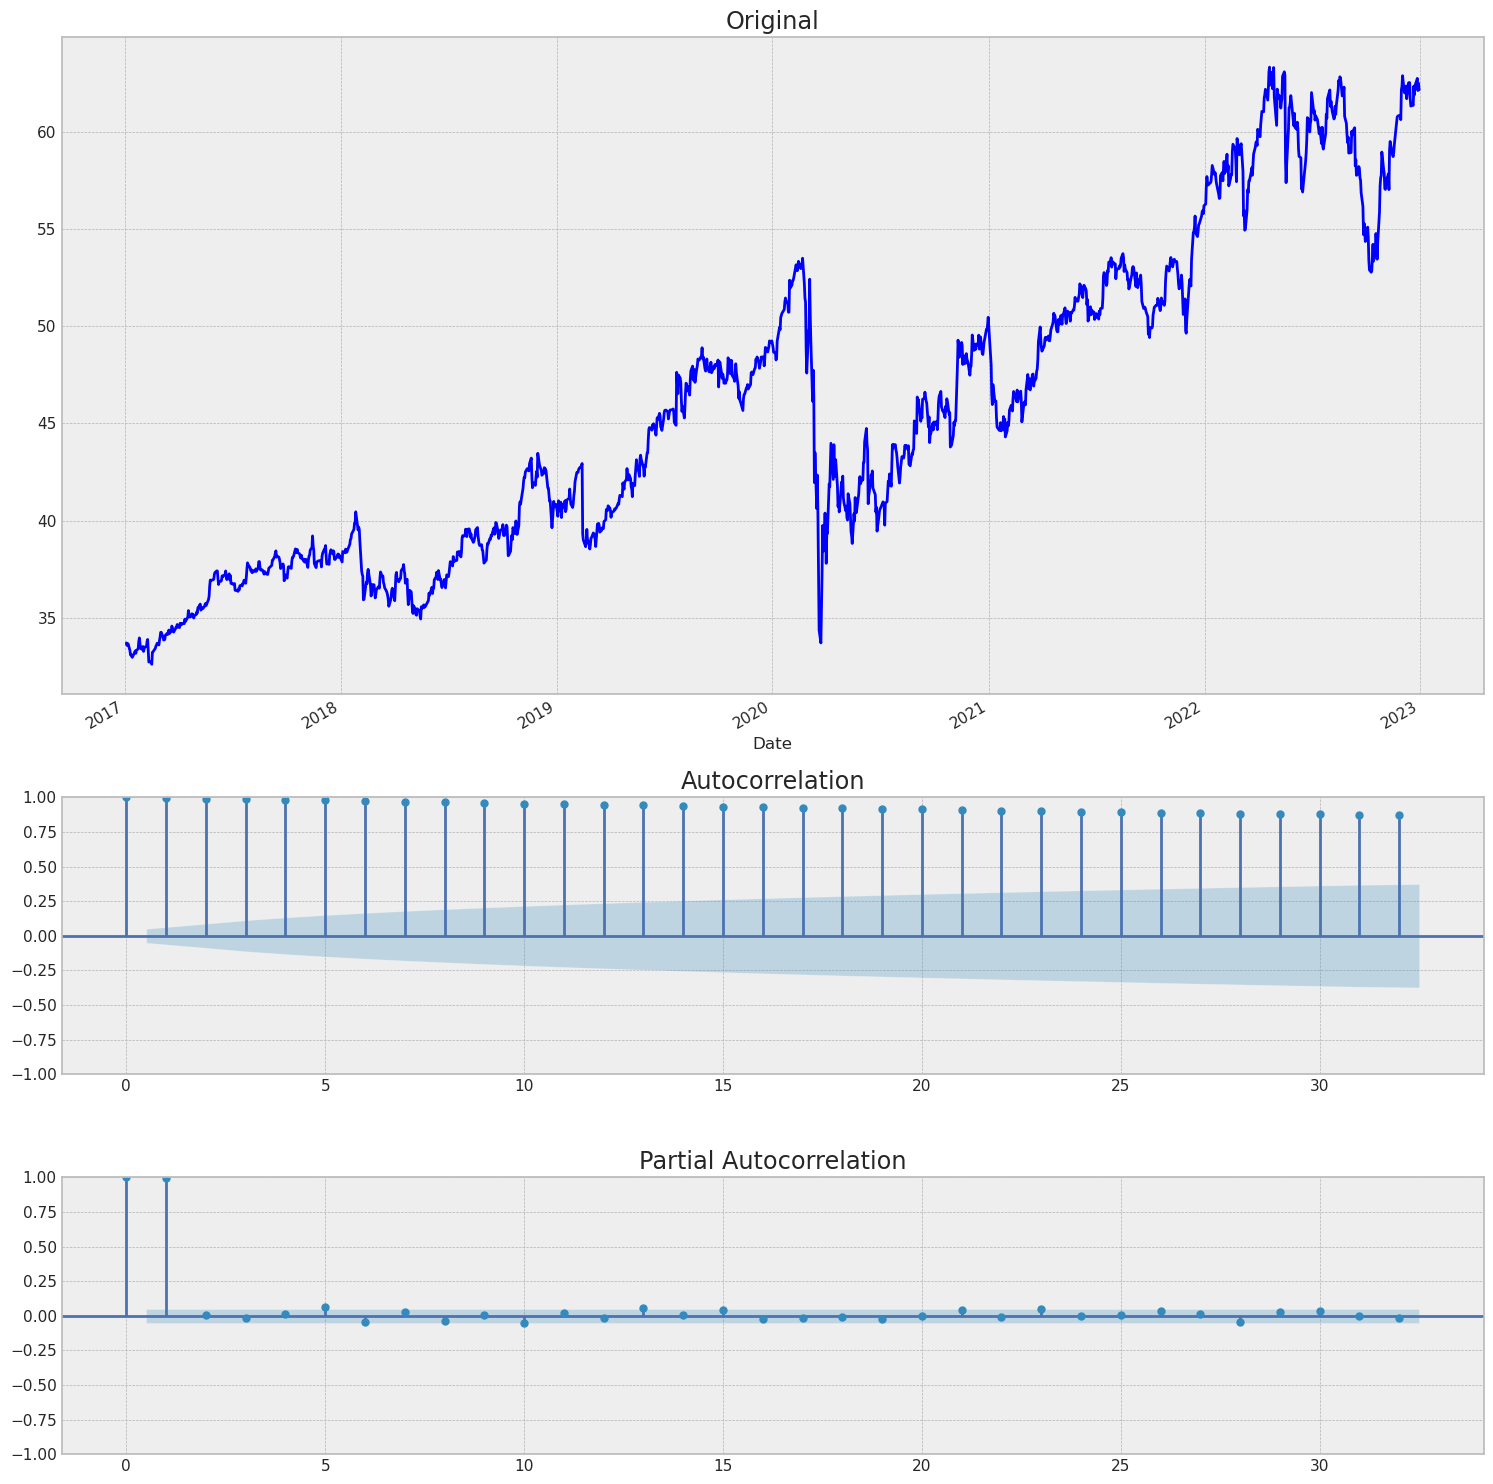

In [46]:
tsplot(df_KO['Close'])

Ряд не является стационарным, на графике виден тренд и это подтверждает тест Дики-Фуллера. Значение p-value составило 0,789, значит у нас нет оснований отвергнуть нулевую гипотезу о нестационарности временного ряда на уровне значимости 5% (0,789 >  0,05). Попробуем привести ряд к стационарному, используя boxcox-преобразование для стабилизации дисперсии и дифференцирование, чтоб избавиться от тренда. После данных преобразований проверим ряд на стационарность.

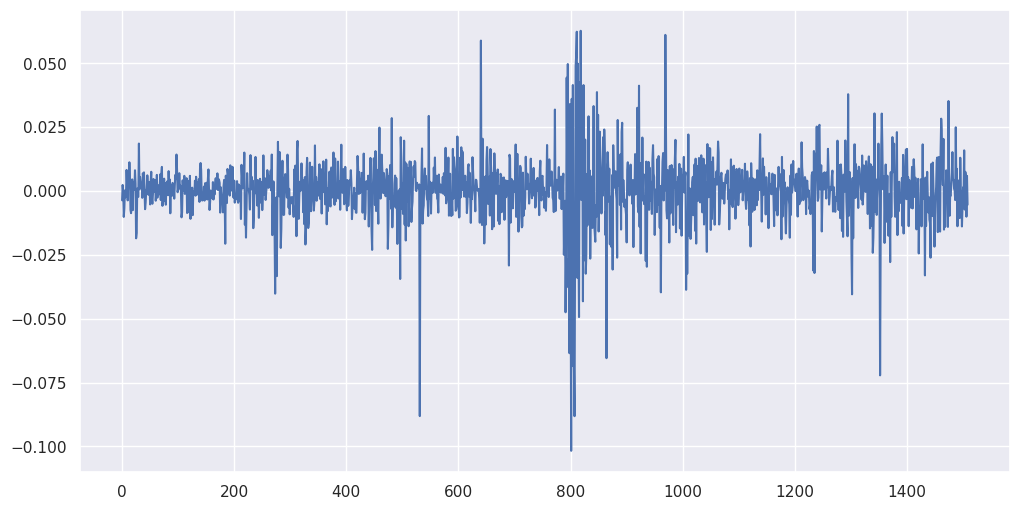

In [49]:
modified_KO = np.diff(boxcox(df_KO['Close'], 0), 1)
plt.figure(figsize=(12,6))
plt.plot(modified_KO)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.216950e+01
p-value                        1.431608e-22
#Lags Used                     1.100000e+01
Number of Observations Used    1.497000e+03
Critical Value (1%)           -3.434726e+00
Critical Value (5%)           -2.863473e+00
Critical Value (10%)          -2.567799e+00
dtype: float64


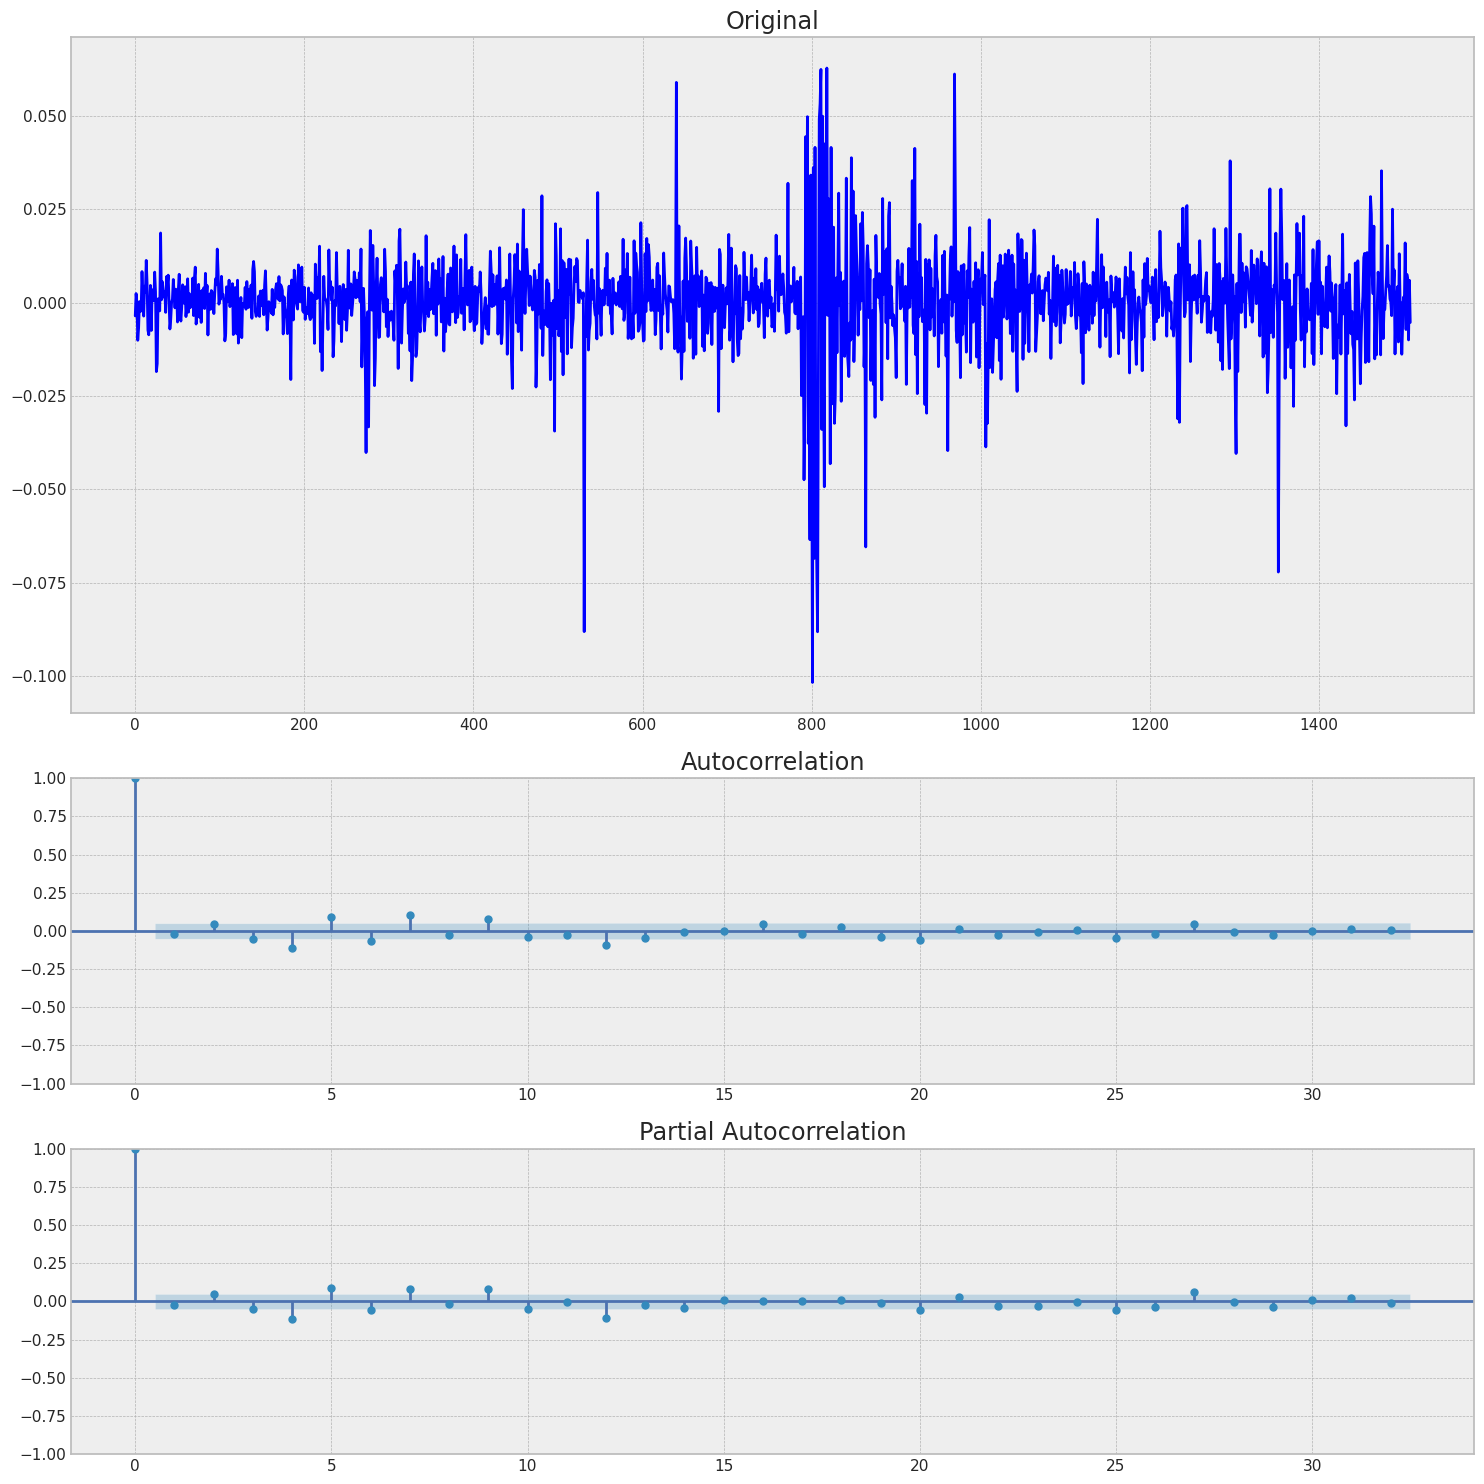

In [50]:
tsplot(modified_KO)

Мы привели ряд к стационарному виду. Тест Дики-Фуллера подтверждает, что ряд стационарен, уровень p-value близок к 0 и менее 0,05. 

## Forecasting

In [118]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [119]:
pred_period = 365

In [120]:
df_prophet = df_KO.reset_index().iloc[:, [0, 4]]
df_prophet = prophet_df.rename(columns={'Date':'ds', 'Close':'y'})
df_prophet['ds'] = prophet_df['ds'].dt.tz_localize(None)

In [123]:
train_data = df_prophet[:-pred_period]  
test_data = df_prophet[-pred_period:]

In [124]:
model = Prophet()
model.fit(train_data)

09:48:53 - cmdstanpy - INFO - Chain [1] start processing


09:48:54 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
future_dates = model.make_future_dataframe(periods=365)  
forecast = model.predict(future_dates)

predictions = forecast.loc[forecast['ds'].isin(test_data['ds'])]

In [126]:
forecast_test = forecast[-len(test_df):]

In [135]:
print('MAPE для прогнозирования на год вперед равна', round(mean_absolute_percentage_error(forecast_test['yhat'].values, test_df['y'].values), 2))

MAPE для прогнозирования на год вперед равна 3.77


<function matplotlib.pyplot.show(close=None, block=None)>

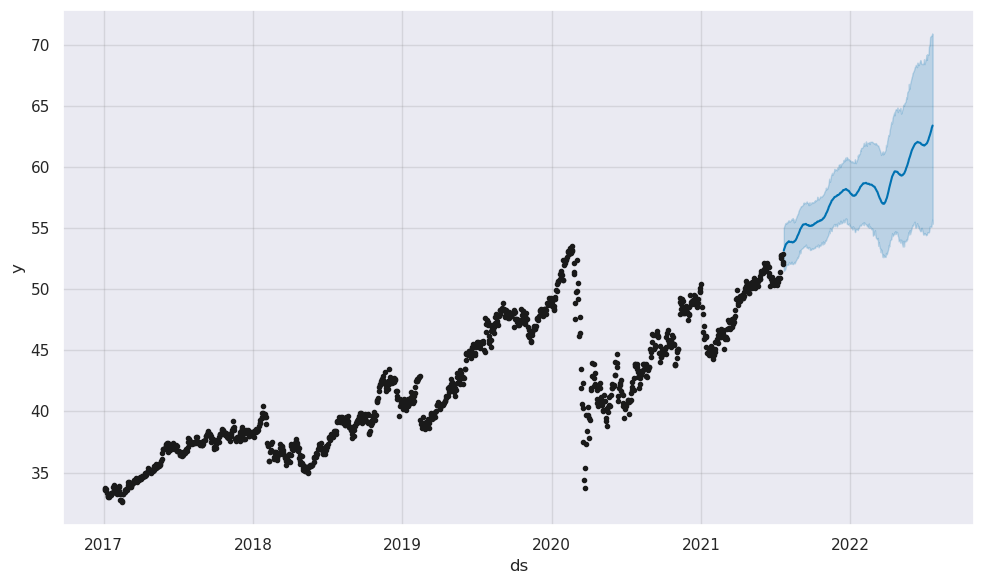

In [165]:
fig = model.plot(predictions)
plt.show

In [163]:
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast) 

In [136]:
model_new = Prophet()
model_new.fit(df_prophet)

11:25:39 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
def show_forecast(period):
    future_pred = model_new.make_future_dataframe(periods=period)
    prediction = model_new.predict(future_pred)
    fig = model_new.plot(prediction)
    plt.title(f'Coca-Cola stock forecast for {period} days')

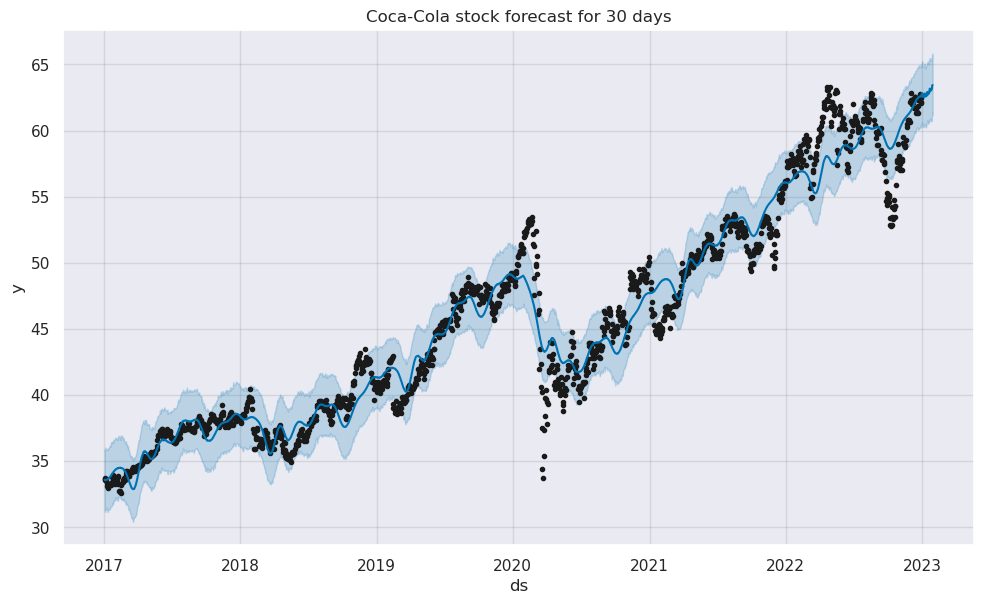

In [153]:
show_forecast(30)

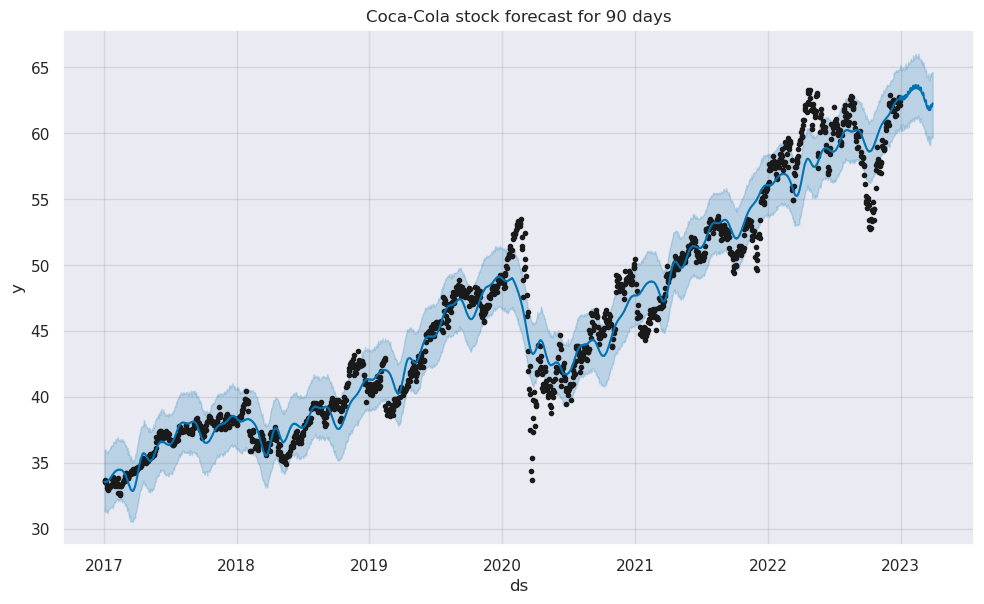

In [154]:
show_forecast(90)

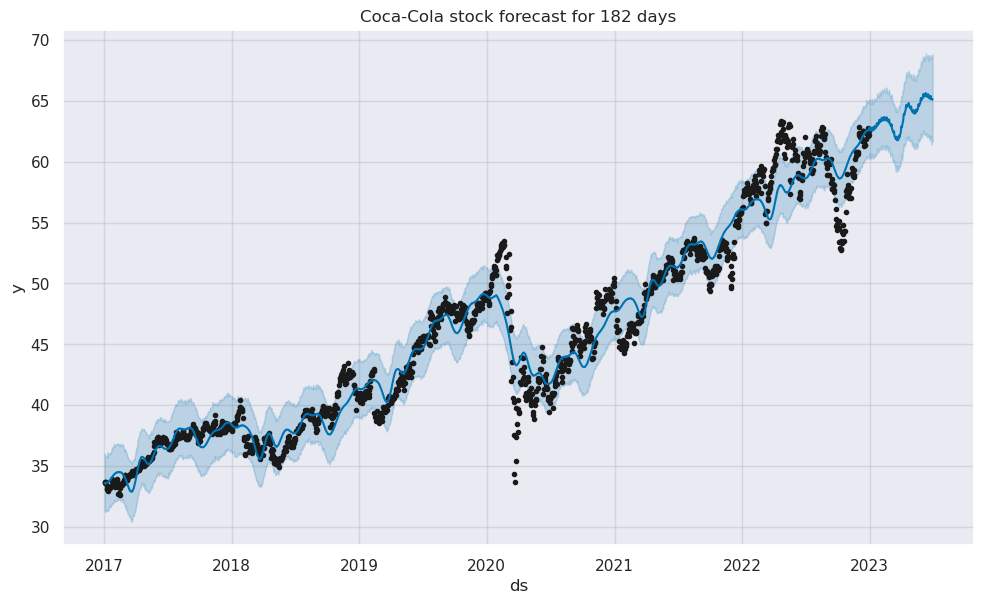

In [155]:
show_forecast(182)

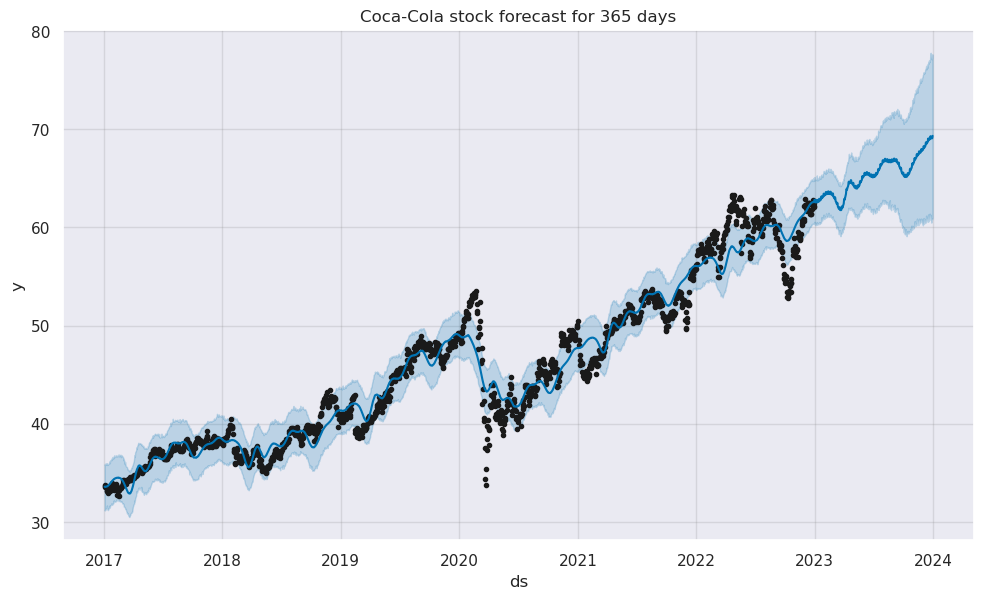

In [156]:
show_forecast(365)

# MERCK

In [90]:
df_MRK = get_price_data('MRK')

## EDA

In [91]:
df_MRK.head(10)

Open       High        Low      Close  \
Date                                                                    
2017-01-03 00:00:00-05:00  45.923737  46.878702  45.846097  46.700130   
2017-01-04 00:00:00-05:00  46.971871  47.197026  46.614730  46.684605   
2017-01-05 00:00:00-05:00  46.754478  47.033982  46.583672  46.669075   
2017-01-06 00:00:00-05:00  46.653548  46.940815  46.218767  46.793297   
2017-01-09 00:00:00-05:00  46.816593  47.732738  46.645784  47.437706   
2017-01-10 00:00:00-05:00  47.515338  47.546396  46.498262  46.521553   
2017-01-11 00:00:00-05:00  48.400439  49.037083  47.165970  47.849197   
2017-01-12 00:00:00-05:00  48.547946  49.099184  48.229625  48.299500   
2017-01-13 00:00:00-05:00  48.392674  48.664412  48.214105  48.400440   
2017-01-17 00:00:00-05:00  48.074355  48.190815  47.515350  47.732742   

                             Volume  
Date                                 
2017-01-03 00:00:00-05:00  12564158  
2017-01-04 00:00:00-05:00   9863671  
2017-01-05 00:00:00-05:00  10581446  
2017-01-06 00:00:00-05:00  10730053  
2017-01-09 00:00:00-05:00  10201861  
2017-01-10 00:00:00-05:00  16036706  
2017-01-11 00:00:00-05:00  34281862  
2017-01-12 00:00:00-05:00  26079899  
2017-01-13 00:00:00-05:00  10447617  
2017-01-17 00:00:00-05:00  11101150

In [92]:
df_MRK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1510 non-null   float64
 1   High    1510 non-null   float64
 2   Low     1510 non-null   float64
 3   Close   1510 non-null   float64
 4   Volume  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [93]:
df_MRK.corr()

Open      High       Low     Close    Volume
Open    1.000000  0.999188  0.999190  0.998493 -0.055501
High    0.999188  1.000000  0.998907  0.999284 -0.043910
Low     0.999190  0.998907  1.000000  0.999252 -0.066533
Close   0.998493  0.999284  0.999252  1.000000 -0.055957
Volume -0.055501 -0.043910 -0.066533 -0.055957  1.000000

In [94]:
df_MRK.describe()

Open         High          Low        Close        Volume
count  1510.000000  1510.000000  1510.000000  1510.000000  1.510000e+03
mean     66.060281    66.644712    65.472413    66.064234  1.109860e+07
std      13.703180    13.861954    13.556895    13.733344  5.639286e+06
min      42.794383    43.155480    42.506315    42.925381  2.343223e+06
25%      51.499640    51.851510    51.302045    51.592528  7.931972e+06
50%      68.181400    68.784612    67.593389    68.140541  9.950584e+06
75%      72.600138    73.072987    72.022465    72.602520  1.263008e+07
max     110.612409   110.612409   109.279855   109.857956  1.024973e+08

In [95]:
statistic_report(df_MRK, 'Close')

Среднее значение: 66.064233812749, доверительный интервал (95%): (65.37099257611081, 66.75747504938718)
Медианное значение: 68.14054107666016
Стандартное отклонение: 13.733343713291053
Максимальное значение: 109.85795593261719
Минимальное значение: 42.92538070678711


У нас есть датасет с ценами на акции фармацевтической компании MERCK. В датасете есть пять столбцов: цена открытия, самая низкая цена, самая высокая цена, цена закрытия и объем акций. Данные записаны ежедневно, за исключением выходных и праздничных дней. Всего в датасете 1697 наблюдений, пропущенных значений нет. Коэффициенты корреляции между ценами Open, Low, High, Close достаточно высоки (не ниже 0,99), дальнейший расчет будет вести по колонке Close. Для данной колонки было определены статистические параметры и среднее значение с 95% вероятностью находится в диапазоне от 69.84 до 71.61.

## Visualization

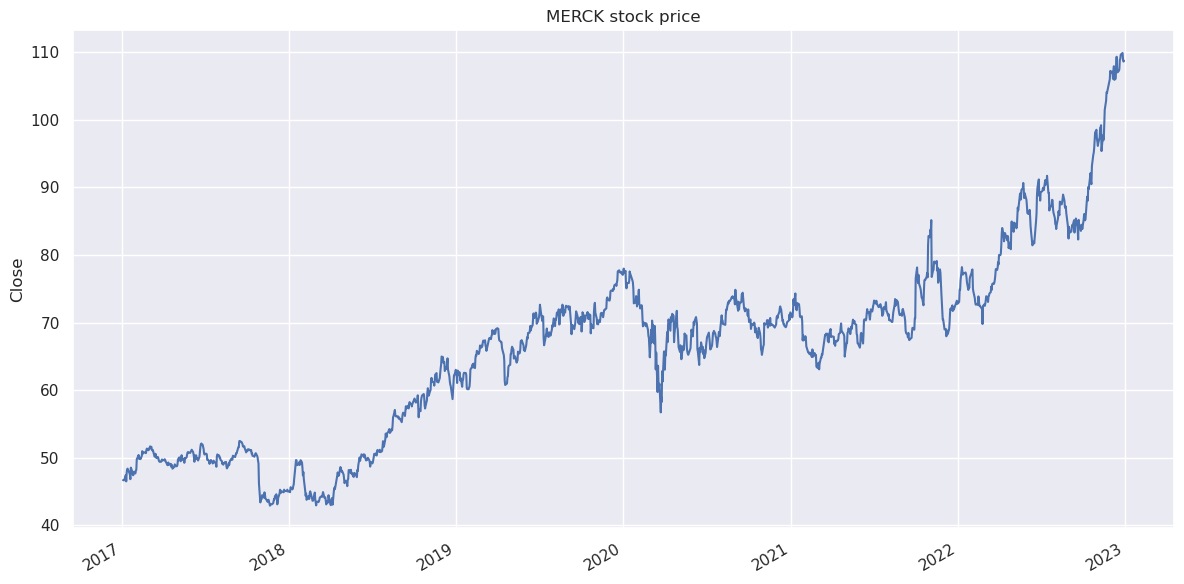

In [96]:
plot_visualization(df_MRK, 'Close', 'MERCK')

<Axes: >

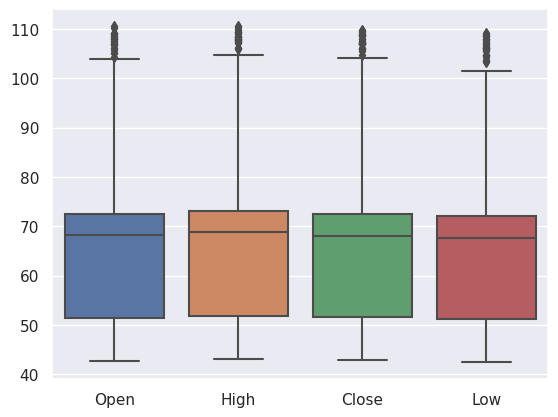

In [97]:
sns.boxplot(data = df_MRK[['Open', 'High', 'Close', 'Low']])

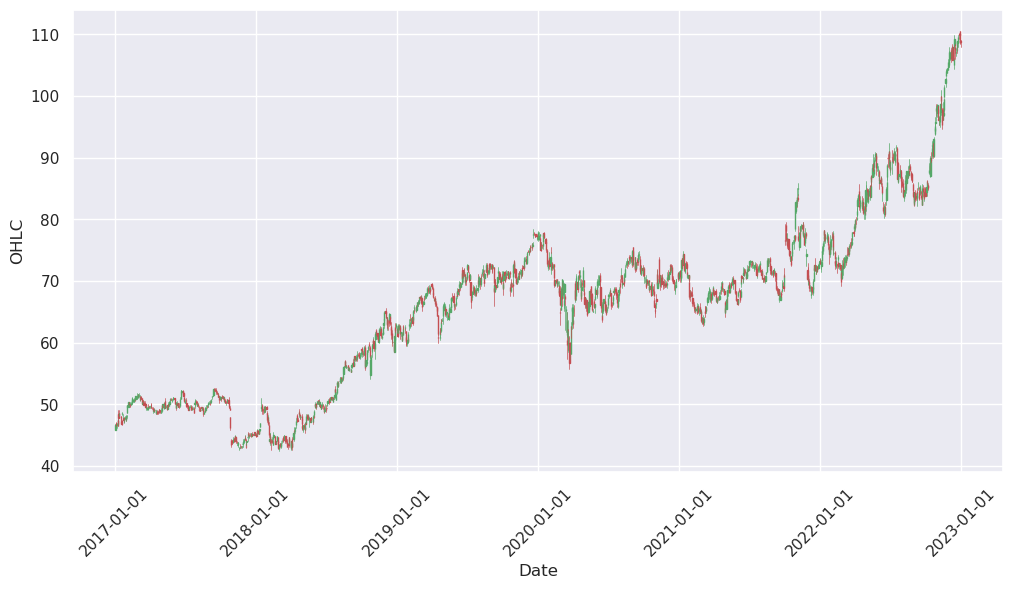

In [100]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(df_MRK, fig.subplots())
plt.show()

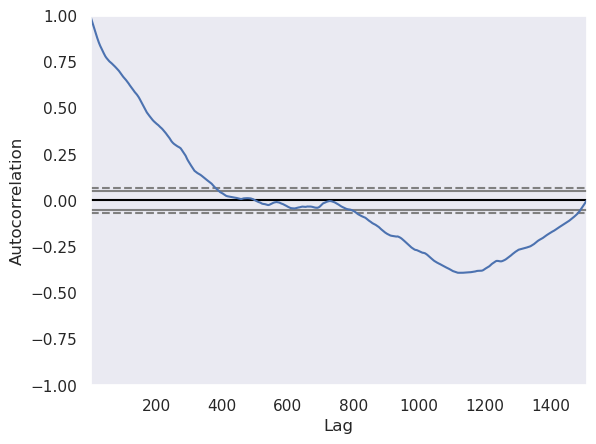

In [101]:
autocorrelation_plot(df_MRK['Close'])
plt.show()

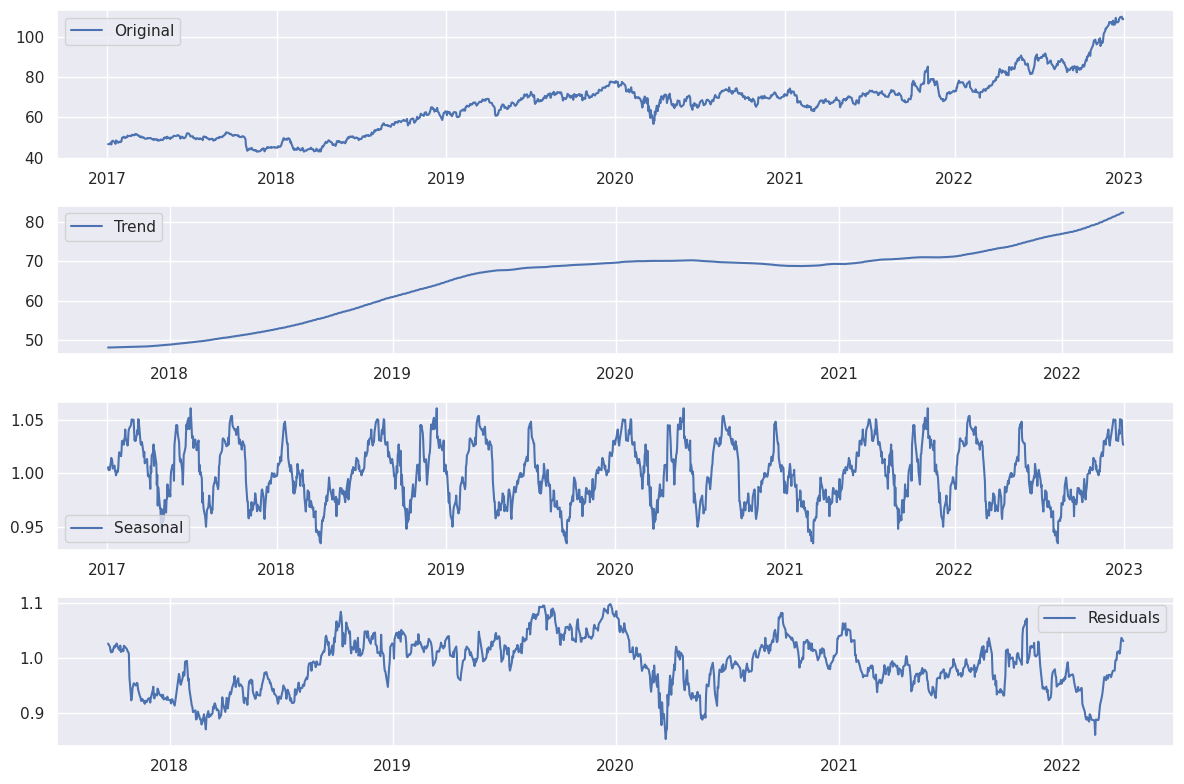

In [102]:
series_decompose(df_MRK['Close'])

<Axes: xlabel='Close', ylabel='Count'>

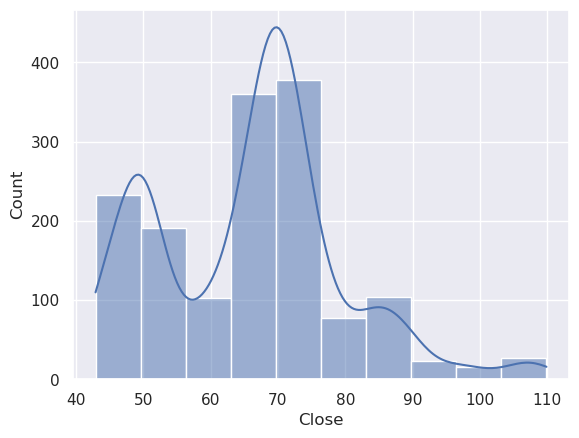

In [103]:
sns.histplot(data=df_MRK, x='Close', bins=10, kde=True)

**Вывод:** Из графиков видно, что распеделение целевой переменной не имеет нормальное распределение. На боксплотах есть выбросы. При разложении ряда получили растущий тренд и  сезонность. 

## Stationarity

Results of Dickey-Fuller Test:
Test Statistic                    0.608013
p-value                           0.987811
#Lags Used                       13.000000
Number of Observations Used    1496.000000
Critical Value (1%)              -3.434729
Critical Value (5%)              -2.863474
Critical Value (10%)             -2.567800
dtype: float64


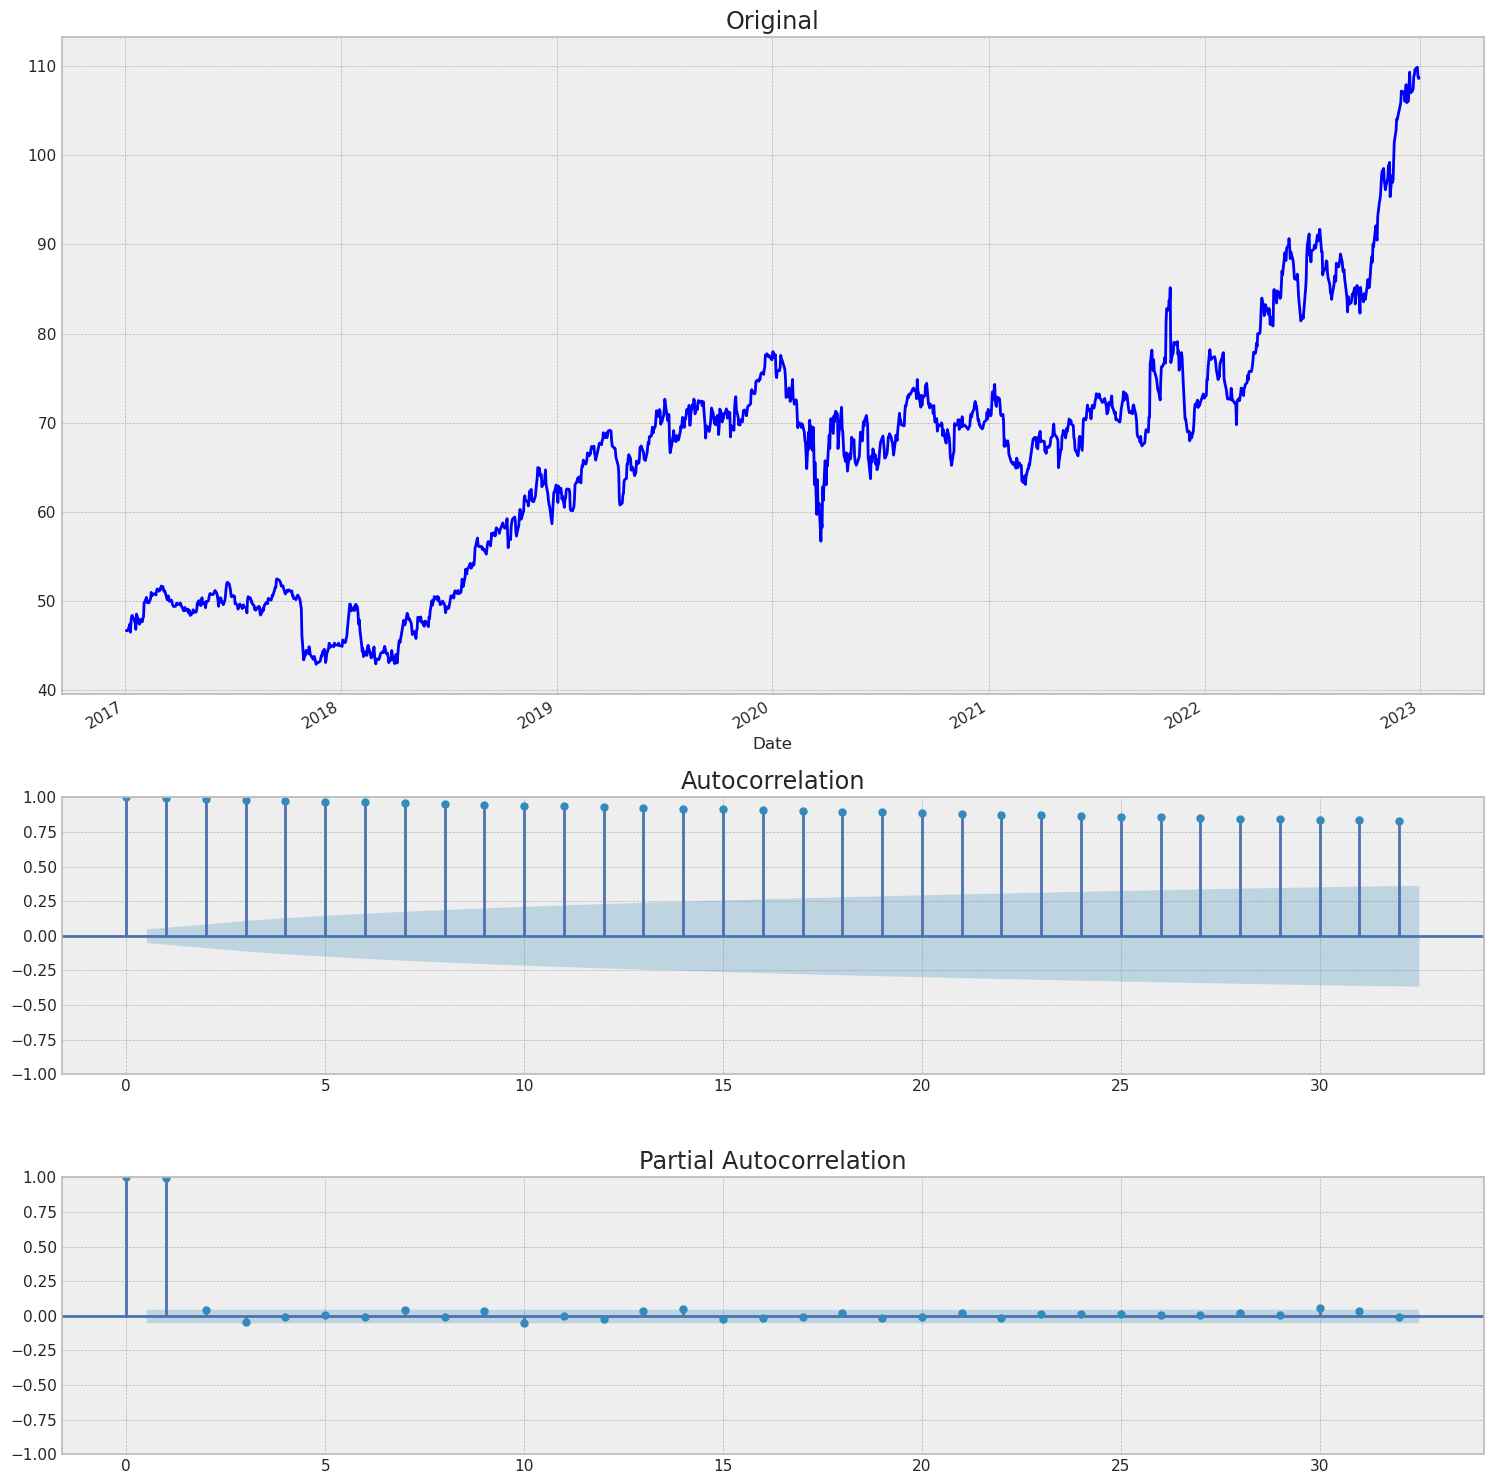

In [108]:
tsplot(df_MRK['Close'])

Ряд не является стационарным, на графике виден тренд и это подтверждает тест Дики-Фуллера. Значение p-value составило 0,862, значит у нас нет оснований отвергнуть нулевую гипотезу о нестационарности временного ряда на уровне значимости 5% (0,862 >  0,05). Попробуем привести ряд к стационарному, используя boxcox-преобразование для стабилизации дисперсии и дифференцирование, чтоб избавиться от тренда. После данных преобразований проверим ряд на стационарность.

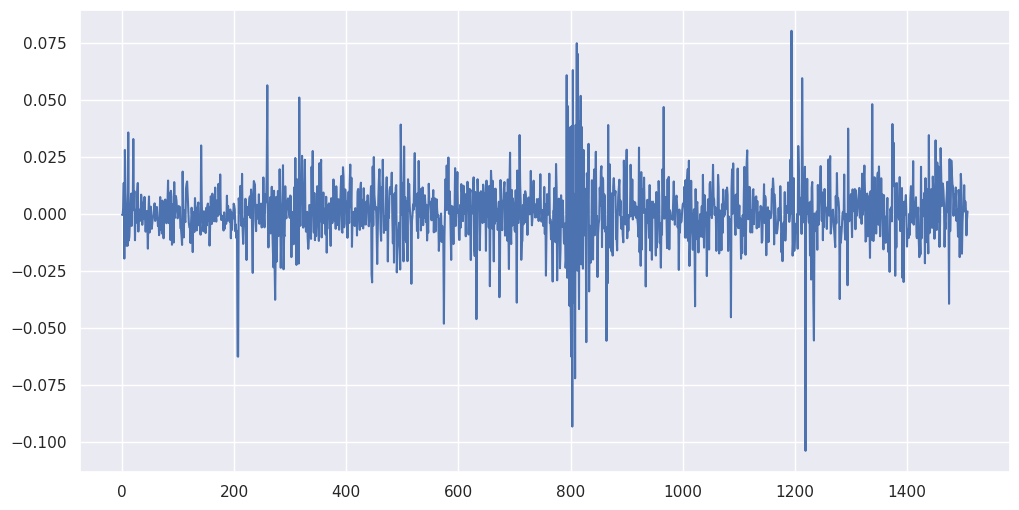

In [109]:
modified_MRK = np.diff(boxcox(df_MRK['Close'], 0), 1)
plt.figure(figsize=(12,6))
plt.plot(modified_MRK)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.186730e+01
p-value                        6.628932e-22
#Lags Used                     1.200000e+01
Number of Observations Used    1.496000e+03
Critical Value (1%)           -3.434729e+00
Critical Value (5%)           -2.863474e+00
Critical Value (10%)          -2.567800e+00
dtype: float64


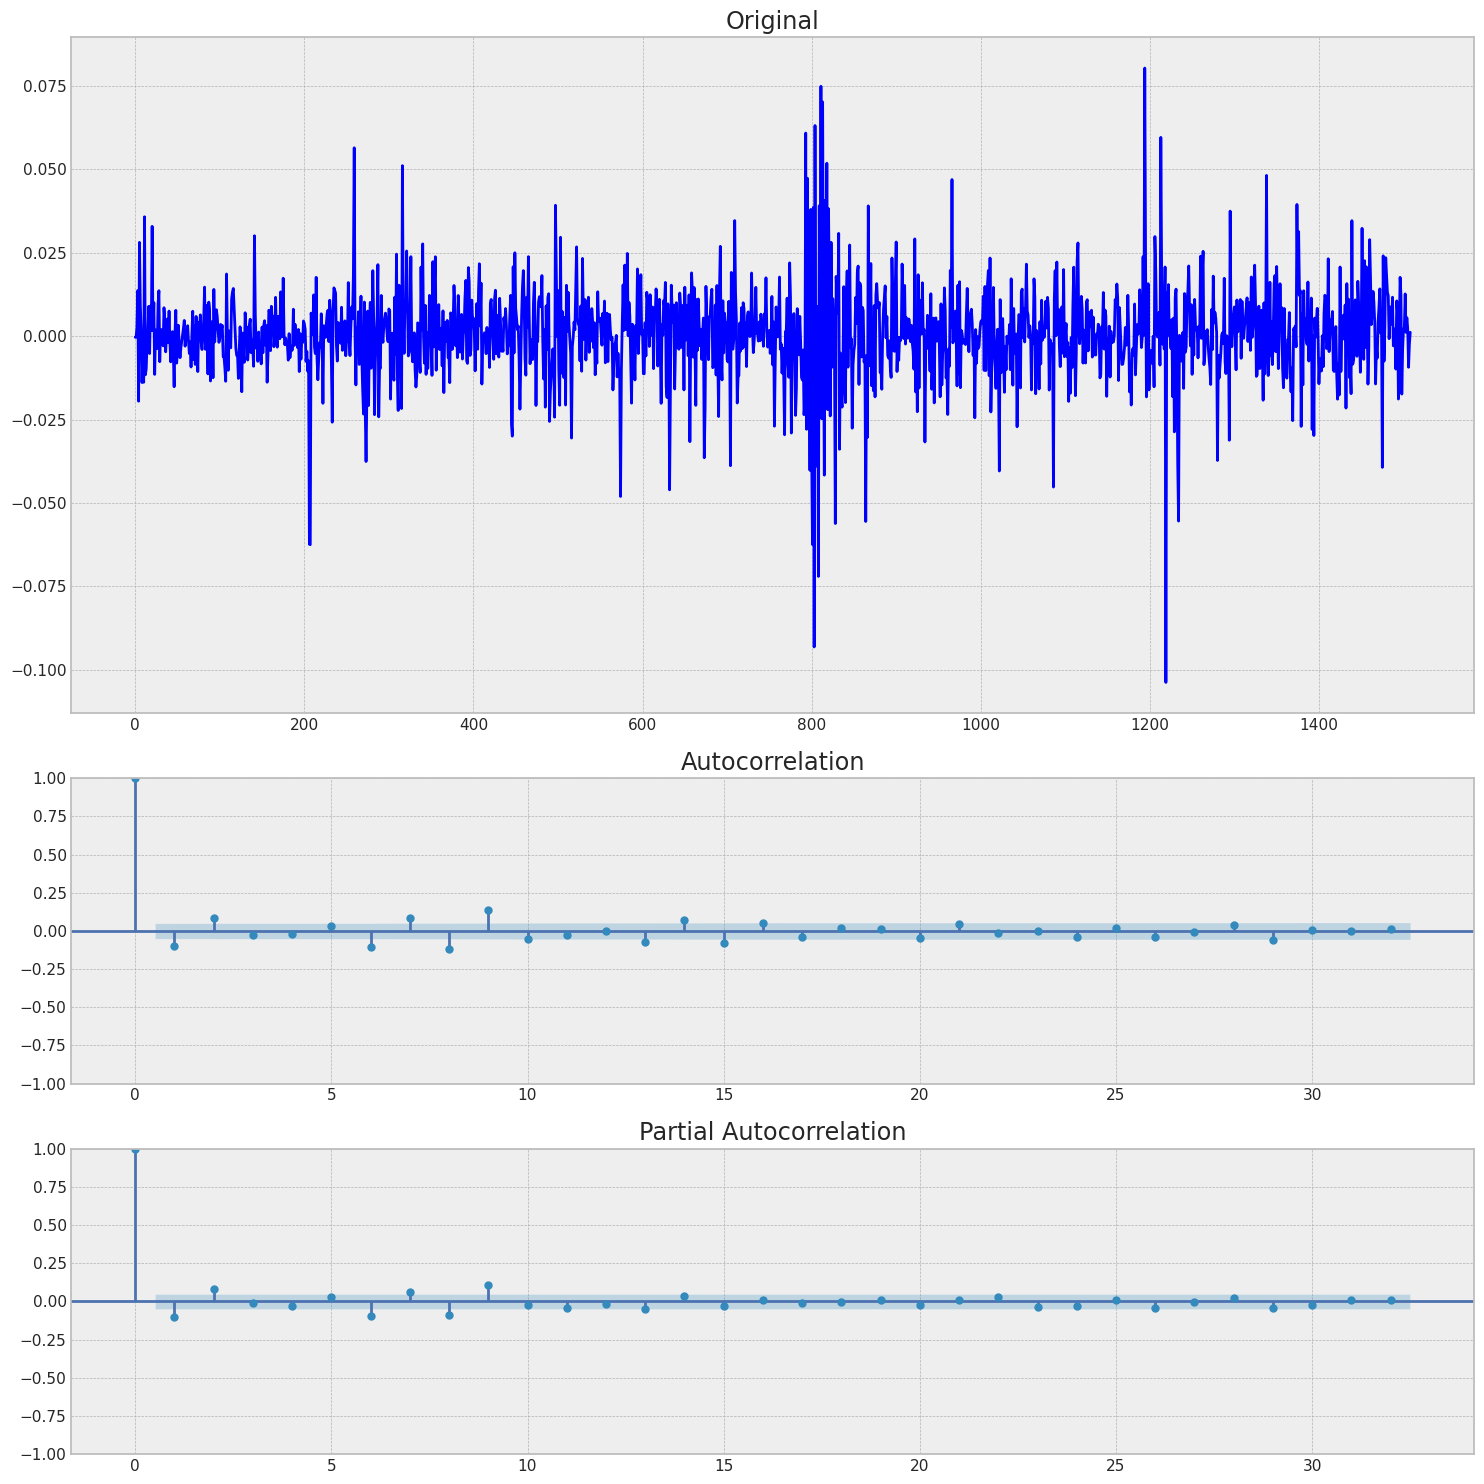

In [110]:
tsplot(modified_MRK)

Мы привели ряд к стационарному виду. Тест Дики-Фуллера подтверждает, что ряд стационарен, уровень p-value близок к 0 и менее 0,05.